# Airbnb NYC Data Pre-processing & ETL

This notebook implements the end-to-end data pipeline to create the final modeling dataset from raw InsideAirbnb snapshots.

**Objective:** Load all monthly listings snapshots and the full reviews history, clean features, engineer the `estimated_occupancy_rate` sample weight, and produce a single, model-ready `listing-month` panel.

### 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
import glob

# --- Configuration ---
# Parent directory containing the 'listings-YY-MM.csv' files and 'nyc-reviews-detailed...csv'
CITY = "toronto"
DATA_DIR = os.path.expanduser(f"~/Downloads/insideairbnb/{CITY}") 
OUTPUT_FILENAME = f"{CITY}_final_modeling_dataset_oct_11.parquet"

# Constants for occupancy estimation
REVIEW_RATE = 0.5        # Assumed percentage of guests who leave a review
AVG_LENGTH_OF_STAY = 3   # Assumed average nights per booking

# Configure pandas display
pd.options.display.max_columns = 100

# --- Validation ---
if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")

# --- Load All Monthly Listings Snapshots ---
listings_files = sorted(glob.glob(os.path.join(DATA_DIR, 'listings-*.csv')))
if not listings_files:
    raise FileNotFoundError(f"No 'listings-*.csv' files found in {DATA_DIR}")

print(f"Found {len(listings_files)} monthly listings files. Loading and concatenating...")

dfs = []
for file in listings_files:
    # low_memory=False handles mixed data types in raw CSVs
    df = pd.read_csv(file, low_memory=False) 
    dfs.append(df)

raw_listings_df = pd.concat(dfs, ignore_index=True)
print(f"Successfully loaded {len(raw_listings_df):,} total listing records.")

# --- Load Full Reviews History ---
reviews_path = os.path.join(DATA_DIR, f'{CITY}-reviews-detailed-insideairbnb.csv')
print(f"Loading reviews from: {os.path.basename(reviews_path)}...")
try:
    raw_reviews_df = pd.read_csv(reviews_path)
    print(f"Successfully loaded {len(raw_reviews_df):,} reviews.")
except FileNotFoundError:
    raise FileNotFoundError(f"Could not find reviews file at: {reviews_path}")

# Display samples
print("\nListings Sample:")
display(raw_listings_df.head(2))
print("\nReviews Sample:")
display(raw_reviews_df.head(2))

Found 12 monthly listings files. Loading and concatenating...
Successfully loaded 259,647 total listing records.
Loading reviews from: toronto-reviews-detailed-insideairbnb.csv...
Successfully loaded 617,247 reviews.

Listings Sample:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d
0,1419,https://www.airbnb.com/rooms/1419,20240905175005,2024-09-06,previous scrape,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Vancouver, Canada","I live in Vancouver, Canada with my husband an...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/7aeea...,https://a0.muscache.com/im/pictures/user/7aeea...,Commercial Drive,1.0,1.0,"['email', 'phone']",t,t,Neighborhood highlights,Little Portugal,NaN,43.6459,-79.42423,Entire home,Entire home/apt,10,NaN,3 baths,5.0,NaN,"[""TV"", ""First aid kit"", ""Wifi"", ""Kitchen"", ""Dr...",NaN,28,730,28.0,28.0,730.0,730.0,28.0,730.0,NaN,t,0,0,0,0,2024-09-06,6,0,0,2015-07-19,2017-08-07,5.00,5.00,5.00,5.00,5.0,5.00,5.00,NaN,f,1,1,0,0,0.05,NaN,NaN,NaN,NaN
1,8077,https://www.airbnb.com/rooms/8077,20240905175005,2024-09-06,previous scrape,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/9a077...,https://a0.muscache.com/im/pictures/user/9a077...,Harbourfront,2.0,3.0,"['email', 'phone']",t,f,NaN,Waterfront Communities-The Island,NaN,43.6408,-79.37673,Private room in rental unit,Private room,2,NaN,1.5 baths,NaN,NaN,"[""Wifi"", ""Pool"", ""TV with standard cable"", ""Sh...",NaN,180,365,180.0,180.0,365.0,365.0,180.0,365.0,NaN,NaN,0,0,0,0,2024-09-06,169,0,0,2009-08-20,2013-08-27,4.84,4.81,4.89,4.87,4.9,4.92,4.83,NaN,f,2,1,1,0,0.92,NaN,NaN,NaN,NaN



Reviews Sample:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,762143,11893239,2014-04-18,727913,Asem,My wife and I stayed at Pat's condo downtown T...
1,762143,15051648,2014-07-01,14434615,Eva,"Our host was very nice, very professional, kno..."


In [25]:
raw_reviews_df['date'].value_counts().sort_index()

date
2009-08-20      1
2009-09-13      1
2009-09-30      1
2009-10-02      1
2009-11-25      1
             ... 
2025-08-02    389
2025-08-03    529
2025-08-04    619
2025-08-05    217
2025-08-06     51
Name: count, Length: 4921, dtype: int64

In [20]:
raw_listings_df.groupby('id').size().value_counts().sort_index()

1      2848
2      2124
3      1947
4      1529
5      1335
6       913
7      1255
8      1144
9      1366
10     1040
11     1382
12    14384
Name: count, dtype: int64

In [21]:
# Compare IDs between raw_listings_df and raw_reviews_df
listings_ids = set(raw_listings_df['id'].unique())
reviews_ids = set(raw_reviews_df['listing_id'].unique())

common_ids = listings_ids & reviews_ids
only_in_listings = listings_ids - reviews_ids
only_in_reviews = reviews_ids - listings_ids

print(f"Total unique IDs in listings: {len(listings_ids)}")
print(f"Total unique IDs in reviews: {len(reviews_ids)}")
print(f"Common IDs: {len(common_ids)}")
print(f"IDs only in listings: {len(only_in_listings)}")
print(f"IDs only in reviews: {len(only_in_reviews)}")

# Optionally, display some samples
print("\nSample common IDs:", list(common_ids)[:5])
print("Sample only in listings:", list(only_in_listings)[:5])
print("Sample only in reviews:", list(only_in_reviews)[:5])

Total unique IDs in listings: 31267
Total unique IDs in reviews: 16391
Common IDs: 16391
IDs only in listings: 14876
IDs only in reviews: 0

Sample common IDs: [np.int64(35880960), np.int64(38731776), np.int64(1136166639130869762), np.int64(1239457201874862082), np.int64(1081313620383858689)]
Sample only in listings: [np.int64(986302774835249152), np.int64(594055665721704452), np.int64(34504709), np.int64(1343715665444208646), np.int64(1022457932458819592)]
Sample only in reviews: []


In [23]:
temp = raw_listings_df[raw_listings_df['id'].isin(common_ids)]
print(temp.shape)
temp.groupby('id').size().value_counts().sort_index()

(172209, 79)


1       266
2       398
3       487
4       307
5       372
6       235
7       357
8       390
9       502
10      566
11      741
12    11770
Name: count, dtype: int64

### 2. Process Historical Reviews

Aggregates the raw reviews into monthly counts per listing.


In [2]:
def compute_monthly_review_counts(reviews: pd.DataFrame) -> pd.DataFrame:
    """Aggregates reviews to get a monthly count per listing."""
    df = reviews.copy()
    df['review_date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['review_date'])
    
    # Create 'yyyy-mm' key
    df['review_year_month'] = df['review_date'].dt.strftime('%Y-%m')
    
    # Group and count
    monthly_counts = (
        df.groupby(['listing_id', 'review_year_month'])
        .size()
        .reset_index(name='reviews_in_month')
    )
    return monthly_counts

print("Aggregating reviews...")
monthly_review_counts_df = compute_monthly_review_counts(raw_reviews_df)
print(f"Generated {len(monthly_review_counts_df):,} listing-month review records.")
display(monthly_review_counts_df.head())

Aggregating reviews...
Generated 212,408 listing-month review records.


,listing_id,review_year_month,reviews_in_month
0,1419,2015-07,1
1,1419,2015-08,1
2,1419,2015-09,1
3,1419,2016-03,1
4,1419,2017-08,2


### 3. Clean & Prepare Listings Data

Applies cleaning, parsing, and type conversion to the concatenated listings data.

In [3]:
def clean_and_prepare_listings(df: pd.DataFrame) -> pd.DataFrame:
    """Applies cleaning and feature engineering to raw listings data."""
    df = df.copy()

    # Standardize ID column
    if 'id' in df.columns:
        df = df.rename(columns={'id': 'listing_id'})

    # 1. Clean Target Price
    df['target_price'] = df['price'].replace(r'[$,]', '', regex=True).astype(float)
    df = df.dropna(subset=['target_price'])
    df = df[df['target_price'] > 0]
    
    # 2. Parse Bathrooms Text
    def parse_bathrooms(text):
        if not isinstance(text, str): return None, None
        text_lower = text.lower()
        # Extract numeric part or handle 'half'
        numeric_val = 0.5 if 'half' in text_lower else pd.to_numeric(pd.Series(text_lower).str.extract(r'(\d+\.?\d*)', expand=False), errors='coerce')[0]
        # Determine type
        bath_type = 'shared' if 'shared' in text_lower else 'private'
        return numeric_val, bath_type

    bath_info = df['bathrooms_text'].apply(parse_bathrooms).apply(pd.Series)
    df['bathrooms_numeric'] = bath_info[0]
    df['bathrooms_type'] = bath_info[1]

    # 3. Convert Percentage Strings to Ratios
    for col in ['host_response_rate', 'host_acceptance_rate']:
        if col in df.columns:
            df[col] = df[col].str.replace('%', '', regex=False).astype(float) / 100.0

    # 4. Convert 't'/'f' to Booleans
    for col in ['host_is_superhost', 'host_identity_verified', 'instant_bookable']:
         if col in df.columns:
            df[col] = (df[col] == 't')

    # 5. Create Temporal Keys
    df['snapshot_date'] = pd.to_datetime(df['last_scraped'])
    df['year_month'] = df['snapshot_date'].dt.strftime('%Y-%m')
    df['month'] = df['snapshot_date'].dt.month
    
    return df

print("Cleaning listings data...")
processed_listings_df = clean_and_prepare_listings(raw_listings_df)
print(f"Cleaned data contains {len(processed_listings_df):,} records.")
display(processed_listings_df[['listing_id', 'year_month', 'target_price', 'bathrooms_numeric']].head())

Cleaning listings data...
Cleaned data contains 191,699 records.


,listing_id,year_month,target_price,bathrooms_numeric
2,26654,2024-09,172.0,1.0
3,27423,2024-09,75.0,1.0
6,40701,2024-09,79.0,1.0
7,44452,2024-09,126.0,1.0
8,45399,2024-09,148.0,1.0


In [4]:
print(processed_listings_df.info())
print(processed_listings_df['month'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 191699 entries, 2 to 259646
Data columns (total 85 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   listing_id                                    191699 non-null  int64         
 1   listing_url                                   191699 non-null  object        
 2   scrape_id                                     191699 non-null  int64         
 3   last_scraped                                  191699 non-null  object        
 4   source                                        191699 non-null  object        
 5   name                                          191699 non-null  object        
 6   description                                   188587 non-null  object        
 7   neighborhood_overview                         87248 non-null   object        
 8   picture_url                                   191699 non-nu

number_of_reviews_l30d
0     134996
1      22691
2      10976
3       7813
4       5399
5       3466
6       2276
7       1441
8        924
9        640
10       443
11       269
12       164
13        95
14        49
15        21
16        14
17         9
18         5
19         1
28         1
29         1
30         1
33         3
42         1
Name: count, dtype: int64


count    191699.000000
mean          0.814871
std           1.758433
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          42.000000
Name: number_of_reviews_l30d, dtype: float64

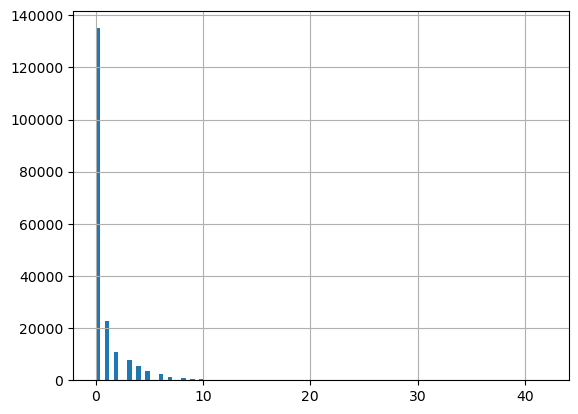

In [18]:
print(processed_listings_df['number_of_reviews_l30d'].value_counts().sort_index())
processed_listings_df['number_of_reviews_l30d'].hist(bins=100)
processed_listings_df['number_of_reviews_l30d'].describe()

number_of_reviews_ly
0.0      46211
1.0       9952
2.0       7446
3.0       5316
4.0       3978
         ...  
128.0        7
133.0        7
145.0        7
149.0        7
175.0        7
Name: count, Length: 117, dtype: int64


count    109207.000000
mean          8.585136
std          15.388841
min           0.000000
25%           0.000000
50%           1.000000
75%          10.000000
max         175.000000
Name: number_of_reviews_ly, dtype: float64

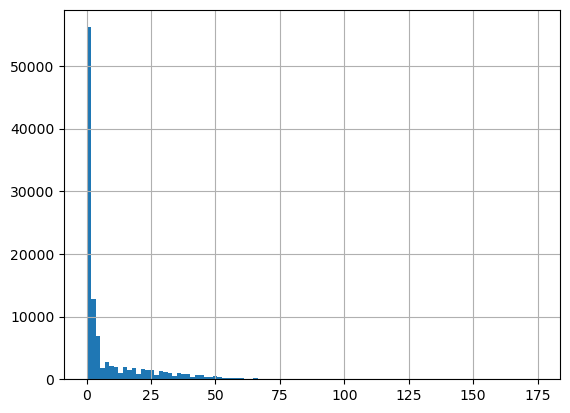

In [19]:
print(processed_listings_df['number_of_reviews_ly'].value_counts().sort_index())
processed_listings_df['number_of_reviews_ly'].hist(bins=100)
processed_listings_df['number_of_reviews_ly'].describe()

count    149582.000000
mean          1.592403
std           1.828834
min           0.010000
25%           0.280000
50%           0.920000
75%           2.310000
max          35.380000
Name: reviews_per_month, dtype: float64

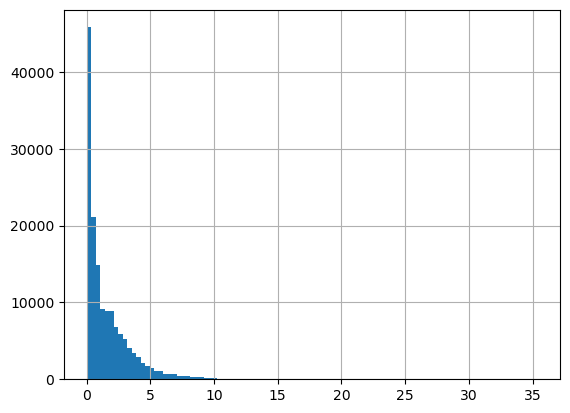

In [16]:
processed_listings_df['reviews_per_month'].hist(bins=100)
processed_listings_df['reviews_per_month'].describe()

### 4. Engineer Rolling Review Activity & Join

Calculates the 90-day rolling review count by creating a complete timeline for every listing, then joins this history to the listings snapshots.

In [5]:
def enrich_with_rolling_reviews(
    listings: pd.DataFrame, monthly_reviews: pd.DataFrame
) -> pd.DataFrame:
    """Calculates 90-day rolling reviews and joins to listings."""
    
    # 1. Build complete timeline of (listing_id, year_month) existences
    all_months = pd.concat([
        listings[['listing_id', 'year_month']],
        monthly_reviews[['listing_id', 'review_year_month']].rename(columns={'review_year_month': 'year_month'})
    ]).drop_duplicates().sort_values(['listing_id', 'year_month'])

    # 2. Map actual review counts to the timeline, filling gaps with 0
    calendar_with_counts = pd.merge(
        all_months,
        monthly_reviews,
        left_on=['listing_id', 'year_month'],
        right_on=['listing_id', 'review_year_month'],
        how='left'
    ).fillna({'reviews_in_month': 0})

    # 3. Calculate 3-month (approx 90-day) rolling sum
    calendar_with_counts = calendar_with_counts.sort_values(['listing_id', 'year_month'])
    rolling_sum = calendar_with_counts.groupby('listing_id')['reviews_in_month'].rolling(window=3, min_periods=1).sum()
    
    calendar_with_counts['reviews_in_last_90_days'] = rolling_sum.reset_index(level=0, drop=True).astype(int)

    # 4. Join back to the listings snapshots (inner join keeps only months we have listing data for)
    final_df = pd.merge(
        listings,
        calendar_with_counts[['listing_id', 'year_month', 'reviews_in_last_90_days']],
        on=['listing_id', 'year_month'],
        how='inner'
    )
    
    return final_df

print("Calculating rolling review counts and joining...")
enriched_df = enrich_with_rolling_reviews(processed_listings_df, monthly_review_counts_df)
print("Done.")

Calculating rolling review counts and joining...
Done.


In [6]:
print(enriched_df.info())
print(enriched_df['month'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191699 entries, 0 to 191698
Data columns (total 86 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   listing_id                                    191699 non-null  int64         
 1   listing_url                                   191699 non-null  object        
 2   scrape_id                                     191699 non-null  int64         
 3   last_scraped                                  191699 non-null  object        
 4   source                                        191699 non-null  object        
 5   name                                          191699 non-null  object        
 6   description                                   188587 non-null  object        
 7   neighborhood_overview                         87248 non-null   object        
 8   picture_url                                   191699 n

### 5. Calculate Estimated Occupancy (Sample Weight)

Converts recent review activity into an estimated occupancy rate, which will serve as the sample weight for the model.

In [7]:
def apply_weighting(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates estimated occupancy rate from review activity."""
    df = df.copy()
    
    # Estimate nights booked based on reviews and assumptions
    estimated_bookings = df['reviews_in_last_90_days'] / REVIEW_RATE
    estimated_nights_booked = estimated_bookings * AVG_LENGTH_OF_STAY
    
    # Calculate rate and cap at 100%
    df['estimated_occupancy_rate'] = (estimated_nights_booked / 30.0).clip(upper=1.0)
    
    # Filter out listings with zero estimated activity (weight 0)
    df = df[df['estimated_occupancy_rate'] > 0].reset_index(drop=True)
    
    return df

print("Calculating sample weights and filtering inactive listings...")
weighted_df = apply_weighting(enriched_df)
print(f"Final dataset size with positive activity: {len(weighted_df):,} records.")
display(weighted_df[['listing_id', 'year_month', 'estimated_occupancy_rate']].head())

Calculating sample weights and filtering inactive listings...
Final dataset size with positive activity: 84,037 records.


,listing_id,year_month,estimated_occupancy_rate
0,26654,2024-09,0.4
1,27423,2024-09,0.4
2,44452,2024-09,0.4
3,45399,2024-09,0.4
4,45893,2024-09,0.4


In [8]:
print(weighted_df.info())
print(weighted_df['month'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84037 entries, 0 to 84036
Data columns (total 87 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   listing_id                                    84037 non-null  int64         
 1   listing_url                                   84037 non-null  object        
 2   scrape_id                                     84037 non-null  int64         
 3   last_scraped                                  84037 non-null  object        
 4   source                                        84037 non-null  object        
 5   name                                          84037 non-null  object        
 6   description                                   83402 non-null  object        
 7   neighborhood_overview                         44054 non-null  object        
 8   picture_url                                   84037 non-null  obje

### 5.5 Drop outliers in target price

In [9]:
# Drop top and bottom 1% of samples by target_price
lower_quantile = weighted_df['target_price'].quantile(0.01)
upper_quantile = weighted_df['target_price'].quantile(0.99)
print(f"Dropping outliers: target_price below {lower_quantile:.2f} or above {upper_quantile:.2f}")

weighted_df = weighted_df[(weighted_df['target_price'] >= lower_quantile) & (weighted_df['target_price'] <= upper_quantile)]

# Drop listings where beds == 0
print(f"Dropping listings with beds == 0...")
weighted_df = weighted_df[weighted_df['beds'] != 0]

print(f"Dataset size after outlier removal: {len(weighted_df):,} records.")

Dropping outliers: target_price below 33.00 or above 794.64
Dropping listings with beds == 0...
Dataset size after outlier removal: 80,721 records.


### 6. Impute Missing Values

Calculates statistics from the dataset to fill missing values in numerical features.

In [10]:
def get_and_apply_imputation(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates stats and imputes missing values."""
    stats = {}
    
    # Median for counts/integers
    median_cols = ["bedrooms", "beds", "bathrooms_numeric"]
    for col in median_cols:
        if col in df.columns: stats[col] = df[col].median()
            
    # Mean for ratings/rates
    mean_cols = [
        "review_scores_rating", "review_scores_cleanliness", "review_scores_checkin",
        "review_scores_communication", "review_scores_location", "review_scores_value",
        "host_response_rate", "host_acceptance_rate",
    ]
    for col in mean_cols:
        if col in df.columns: stats[col] = df[col].mean()
            
    print(f"Imputing with statistics: {stats}")
    return df.fillna(stats)

print("Imputing missing values...")
imputed_df = get_and_apply_imputation(weighted_df)

Imputing missing values...
Imputing with statistics: {'bedrooms': np.float64(1.0), 'beds': np.float64(1.0), 'bathrooms_numeric': np.float64(1.0), 'review_scores_rating': np.float64(4.833117607364306), 'review_scores_cleanliness': np.float64(4.801496739283025), 'review_scores_checkin': np.float64(4.876511313314362), 'review_scores_communication': np.float64(4.903319082683545), 'review_scores_location': np.float64(4.858013757194451), 'review_scores_value': np.float64(4.741605686647354), 'host_response_rate': np.float64(0.9835238334567771), 'host_acceptance_rate': np.float64(0.9081531443973617)}


In [11]:
print(imputed_df.info())
print(imputed_df['month'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 80721 entries, 0 to 84035
Data columns (total 87 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   listing_id                                    80721 non-null  int64         
 1   listing_url                                   80721 non-null  object        
 2   scrape_id                                     80721 non-null  int64         
 3   last_scraped                                  80721 non-null  object        
 4   source                                        80721 non-null  object        
 5   name                                          80721 non-null  object        
 6   description                                   80122 non-null  object        
 7   neighborhood_overview                         42828 non-null  object        
 8   picture_url                                   80721 non-null  object   

<Axes: >

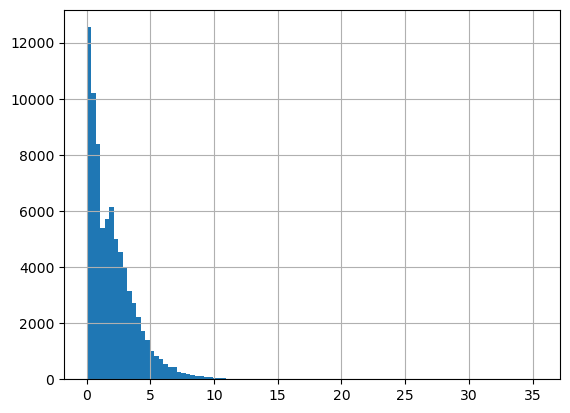

In [14]:
imputed_df['reviews_per_month'].hist(bins=100)

### 7. Finalize & Save Modeling Dataset

Selects the columns defined in the schema and saves the result to a robust file format (Parquet).

In [43]:
# Defined in DATASET-SCHEMA.md
FINAL_COLUMNS_ORDER = [
    "listing_id", "year_month", "target_price", "estimated_occupancy_rate",
    "latitude", "longitude", "neighbourhood_cleansed", "property_type", "room_type",
    "accommodates", "bedrooms", "beds", "bathrooms_numeric", "bathrooms_type",
    "amenities", "review_scores_rating", "review_scores_cleanliness",
    "review_scores_checkin", "review_scores_communication", "review_scores_location",
    "review_scores_value", "number_of_reviews_ltm", "host_is_superhost",
    "host_response_rate", "host_acceptance_rate", "host_identity_verified",
    "instant_bookable", "month"
]

# Ensure all columns exist
for col in FINAL_COLUMNS_ORDER:
    if col not in imputed_df.columns:
        imputed_df[col] = np.nan

# Select and reorder
final_df = imputed_df[FINAL_COLUMNS_ORDER]

print("\n--- Final Dataset Summary ---")
final_df.info()
display(final_df.head())

# Save to Parquet
output_path = os.path.join(DATA_DIR, OUTPUT_FILENAME)
print(f"\nSaving to {output_path}...")
final_df.to_parquet(output_path, index=False)
print("Done.")


--- Final Dataset Summary ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84037 entries, 0 to 84036
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   84037 non-null  int64  
 1   year_month                   84037 non-null  object 
 2   target_price                 84037 non-null  float64
 3   estimated_occupancy_rate     84037 non-null  float64
 4   latitude                     84037 non-null  float64
 5   longitude                    84037 non-null  float64
 6   neighbourhood_cleansed       84037 non-null  object 
 7   property_type                84037 non-null  object 
 8   room_type                    84037 non-null  object 
 9   accommodates                 84037 non-null  int64  
 10  bedrooms                     84037 non-null  float64
 11  beds                         84037 non-null  float64
 12  bathrooms_numeric            84037 non-null

,listing_id,year_month,target_price,estimated_occupancy_rate,latitude,longitude,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,beds,bathrooms_numeric,bathrooms_type,amenities,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews_ltm,host_is_superhost,host_response_rate,host_acceptance_rate,host_identity_verified,instant_bookable,month
0,26654,2024-09,172.0,0.133333,43.64608,-79.39032,Waterfront Communities-The Island,Entire condo,Entire home/apt,4,1.0,2.0,1.0,private,"[""Wifi"", ""Paid parking on premises"", ""Essentia...",4.79,4.79,4.64,4.76,4.86,4.67,0,True,1.000000,0.38,True,False,9
1,27423,2024-09,75.0,0.133333,43.66884,-79.32725,South Riverdale,Entire rental unit,Entire home/apt,1,0.0,1.0,1.0,private,"[""Essentials"", ""Central heating"", ""Ethernet co...",4.93,4.87,5.00,5.00,4.87,4.87,2,True,0.983228,1.00,True,False,9
2,44452,2024-09,126.0,0.133333,43.67193,-79.38590,Rosedale-Moore Park,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,private,"[""Wifi"", ""Dryer"", ""Essentials"", ""Long term sta...",4.18,4.03,4.79,4.84,4.95,4.23,1,True,0.770000,0.62,True,False,9
3,45399,2024-09,148.0,0.133333,43.66123,-79.38336,Bay Street Corridor,Entire condo,Entire home/apt,3,0.0,1.0,1.0,private,"[""Wifi"", ""Dryer"", ""Essentials"", ""Cleaning prod...",4.17,3.97,4.63,4.69,4.92,4.21,4,True,0.770000,0.62,True,False,9
4,45893,2024-09,90.0,0.133333,43.67180,-79.38488,Rosedale-Moore Park,Private room in rental unit,Private room,1,1.0,1.0,1.0,private,"[""Wifi"", ""Dryer"", ""Essentials"", ""Elevator"", ""D...",4.42,3.95,4.50,4.80,4.85,4.25,1,True,0.770000,0.62,True,False,9



Saving to /Users/arvindsuresh/Downloads/insideairbnb/toronto/toronto_final_modeling_dataset.parquet...
Done.


In [44]:
print(final_df.info())
print(final_df['month'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84037 entries, 0 to 84036
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   84037 non-null  int64  
 1   year_month                   84037 non-null  object 
 2   target_price                 84037 non-null  float64
 3   estimated_occupancy_rate     84037 non-null  float64
 4   latitude                     84037 non-null  float64
 5   longitude                    84037 non-null  float64
 6   neighbourhood_cleansed       84037 non-null  object 
 7   property_type                84037 non-null  object 
 8   room_type                    84037 non-null  object 
 9   accommodates                 84037 non-null  int64  
 10  bedrooms                     84037 non-null  float64
 11  beds                         84037 non-null  float64
 12  bathrooms_numeric            84037 non-null  float64
 13  bathrooms_type  